In [1]:
import numpy as np
import xarray as xr
import os
import fnmatch
from tqdm.autonotebook import tqdm
import dask
import sys
sys.path.insert(0, '/home/jovyan/CMIP6cf/cmip6cf/')
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%config InlineBackend.figure_format = 'retina'


/tmp/ipykernel_403/3363248783.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Load output:

in_dir = '/home/jovyan/CMIP6cf/output/dependence/sfcWind_pr_europe/40yr_p98_lag0d_declus1d/'
output_files = []
for root, dirs, files in os.walk(in_dir, topdown=False):
    for name in files:
        output_files.append(os.path.join(root, name))
ssps = ['ssp245','ssp585']
for s,ssp in enumerate(ssps):
    ssp_ds = xr.open_mfdataset(fnmatch.filter(output_files,'*'+ssp+'*'),concat_dim='source_id',combine='nested',coords='minimal',compat='override',join='outer')
    ssp_ds = ssp_ds.assign_coords({'source_id':[s.split('/')[8] for s in fnmatch.filter(output_files,'*'+ssp+'*')]})
    if s==0:
        ds = ssp_ds
    else:
        ds = xr.concat((ds,ssp_ds),dim='ssp',coords='minimal',compat='override',join='outer')
ds = ds.assign_coords({'ssp':ssps})

#04-05-23
compl = ds['complete_window'].copy(deep=True)

In [2]:
in_dir = '/home/jovyan/CMIP6cf/output/dependence/sfcWind_pr_europe/40yr_p98_lag0d_declus1d_ref2000/'
output_files = []
ssps = ['ssp245','ssp585']

source_ids = [k for k in os.listdir(in_dir) if ~k.startswith('.')]

for s,ssp in enumerate(ssps):
    models = []
    for so,source_id in enumerate(source_ids): #loop over models
        model_path = os.path.join(in_dir,source_id)
        model_ssp_ds = {}

        files = [os.path.join(model_path,f) for f in os.listdir(model_path) if ssp in f]
        if len(files)>0:
            model_ds = xr.open_mfdataset(files,concat_dim='member_id',combine='nested',coords='minimal',compat='override',join='outer').chunk(member_id=100)
            models.append(source_id)
        else:
            continue

        if so==0:
            ssp_ds = model_ds
        else:
            ssp_ds = xr.concat((ssp_ds,model_ds),dim='source_id',coords='minimal',join='outer')
            
    ssp_ds = ssp_ds.assign_coords({'source_id':models})   
    
    
    if s==0:
        ds = ssp_ds
    else:
        ds = xr.concat((ds,ssp_ds),dim='ssp')
ds = ds.assign_coords({'ssp':ssps})

In [3]:
ds = ds[['num_co_occurring','num_pr_peaks','num_sfcWind_peaks','complete_window','num_co_occurring_pr_driven','num_co_occurring_sfcWind_driven','num_co_occurring_both_driven']]

Compute slopes change/window:

In [4]:
complete = ds.complete_window.sel(window=slice(1850,2100)).sum(dim='window')==len(ds.complete_window.sel(window=slice(1850,2100)).window)
ds = ds.where(complete) #require runs to be complete from 1970 to 2100

ds = ds.sel(window=slice(1980,2100))
timesteps = xr.DataArray(data=np.arange(len(ds.window)),dims=['window'],coords=dict(window=ds.window))
'''
ds['ktau_slope'] = (1/np.diff(ds.window)[0])*xr.corr(ds.ktau,timesteps,dim='window')*ds.ktau.std(dim='window')/timesteps.std(dim='window')
ds['utdc_slope'] = (1/np.diff(ds.window)[0])*xr.corr(ds.utdc,timesteps,dim='window')*ds.utdc.std(dim='window')/timesteps.std(dim='window')
ds['num_co_occurring_slope'] = (1/np.diff(ds.window)[0])*xr.corr(ds.num_co_occurring,timesteps,dim='window')*ds.num_co_occurring.std(dim='window')/timesteps.std(dim='window')
'''
#ds.load()

"\nds['ktau_slope'] = (1/np.diff(ds.window)[0])*xr.corr(ds.ktau,timesteps,dim='window')*ds.ktau.std(dim='window')/timesteps.std(dim='window')\nds['utdc_slope'] = (1/np.diff(ds.window)[0])*xr.corr(ds.utdc,timesteps,dim='window')*ds.utdc.std(dim='window')/timesteps.std(dim='window')\nds['num_co_occurring_slope'] = (1/np.diff(ds.window)[0])*xr.corr(ds.num_co_occurring,timesteps,dim='window')*ds.num_co_occurring.std(dim='window')/timesteps.std(dim='window')\n"

In [7]:
ds_intersect = ds.where(np.isfinite(ds.complete_window.isel(window=-1)).all(dim=['ssp','longitude','latitude']))

In [8]:
ds_intersect.load()

<xarray.Dataset>
Dimensions:                          (ssp: 2, source_id: 13, member_id: 67,
                                      month: 12, window: 6, latitude: 34,
                                      longitude: 51)
Coordinates:
  * member_id                        (member_id) object 'r101i1p1f1' ... 'r7i...
  * longitude                        (longitude) int64 -30 -29 -28 ... 18 19 20
  * latitude                         (latitude) int64 35 36 37 38 ... 66 67 68
  * window                           (window) int64 1980 2000 2020 ... 2060 2080
  * month                            (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * source_id                        (source_id) <U15 'CESM2' ... 'TaiESM1'
    height                           float64 10.0
  * ssp                              (ssp) <U6 'ssp245' 'ssp585'
Data variables:
    num_co_occurring                 (ssp, source_id, member_id, month, window, latitude, longitude) float64 ...
    num_pr_peaks                     (ssp, source_id, member_id, month, window, latitude, longitude) float64 ...
    num_sfcWind_peaks                (ssp, source_id, member_id, month, window, latitude, longitude) float64 ...
    complete_window                  (ssp, source_id, member_id, window, latitude, longitude) float64 ...
    num_co_occurring_pr_driven       (ssp, source_id, member_id, latitude, longitude) float64 ...
    num_co_occurring_sfcWind_driven  (ssp, source_id, member_id, latitude, longitude) float64 ...
    num_co_occurring_both_driven     (ssp, source_id, member_id, latitude, longitude) float64 ...
Attributes: (12/69)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.6.0
    ...                               ...
    intake_esm_dataset_key:           CMIP.CMCC.CMCC-ESM2.historical.r1i1p1f1...
    original_key:                     CMCC-ESM2.gn.historical.day.r1i1p1f1
    regrid_method:                    bilinear
    window_length:                    40
    declustering:                     Rolling window of 1 days
    allowed_lag:                      0

**Ensemble mean Kendall's Tau:**

Using intersection of ssp's for comparison between scenarios:

**Ensemble mean's UTDC**

Intersection

Using all data per ssp:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


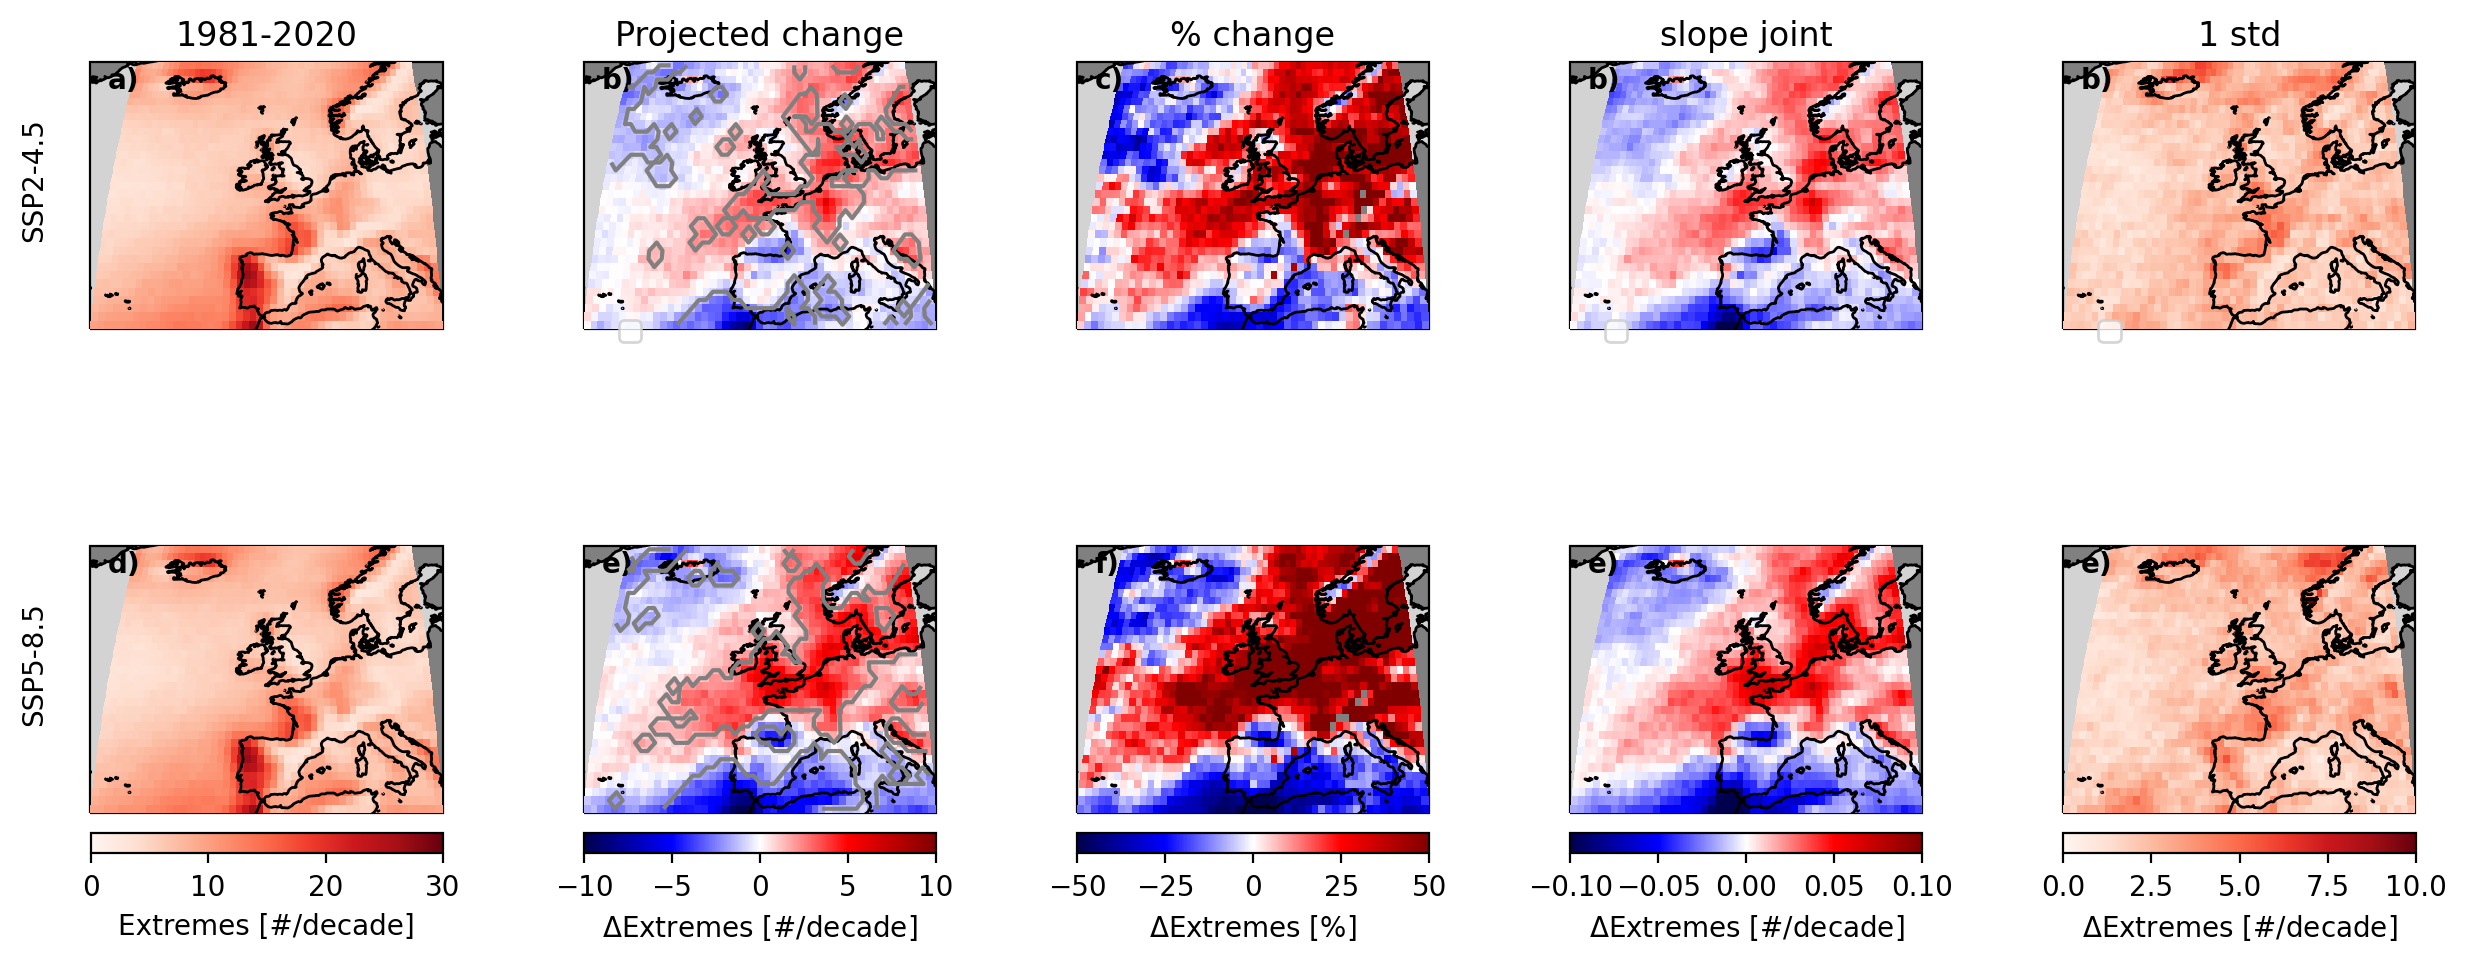

In [23]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,5)
gs.update(wspace=.4,hspace=.1)
    
for s,ssp in enumerate(ssps):
    ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
    #ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    #1991-2020
    ax = plt.subplot(gs[s,0],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id')).plot(cmap='Reds',vmin=0,vmax=30,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Extremes [#/decade]')
        ax.set_title('')
    if s==0:
        ax.set_title('1981-2020')

    ax.annotate(['SSP2-4.5','SSP5-8.5'][s],(-.2,.35),xycoords='axes fraction',rotation=90)
    ax.annotate('ad'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
       
    ax = plt.subplot(gs[s,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id')
    ens_diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')

    num_agree = ((diff*ens_diff)>0).sum(dim='source_id')
    fraction_exceeds = (num_agree>=.75*len(diff.source_id))
        
    #sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[~fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,edgecolor='black',transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    mean_lt_std = np.abs(ens_diff)>np.abs(ssp_ds_diff.num_co_occurring.mean(dim='member_id').std(dim='source_id'))
    
    sc=(.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    mean_lt_std.plot.contour(levels=[0,1],ax=ax,transform=ccrs.PlateCarree(),zorder=5,colors=['grey','grey'])
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('Projected change')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
        
    ax = plt.subplot(gs[s,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(100*ssp_ds_diff.num_co_occurring/ssp_ds_present.num_co_occurring).mean(dim='member_id').mean(dim='source_id').plot(cmap='seismic',vmin=-50,vmax=50,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [%]')
        ax.set_title('')
    if s==0:
        ax.set_title('% change')
    ax.annotate('cf'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
#meaning of number of joint extremes?

#fig.savefig('Figures/ensmean_num_joint_extremes_knmi.pdf',format='pdf',dpi=300,bbox_inches='tight')


    
    ax = plt.subplot(gs[s,3],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_co_occurring,timesteps,dim='window')*ssp_ds.num_co_occurring.std(dim='window')/timesteps.std(dim='window')
    sc=(.25*slope.mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)    
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope joint')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    
    ax = plt.subplot(gs[s,4],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    
    sc=(.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').std(dim='source_id')).plot(cmap='Reds',vmin=0,vmax=10,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)    
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('1 std')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    
    
    
    '''
    #fraction
    ax = plt.subplot(gs[s,4],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_sfcWind_peaks,timesteps,dim='window')*ssp_ds.num_sfcWind_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope sfcWind')
    if s==1:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')  
    
    
    ax = plt.subplot(gs[s,5],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_pr_peaks,timesteps,dim='window')*ssp_ds.num_pr_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope pr')
    if s==1:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    '''

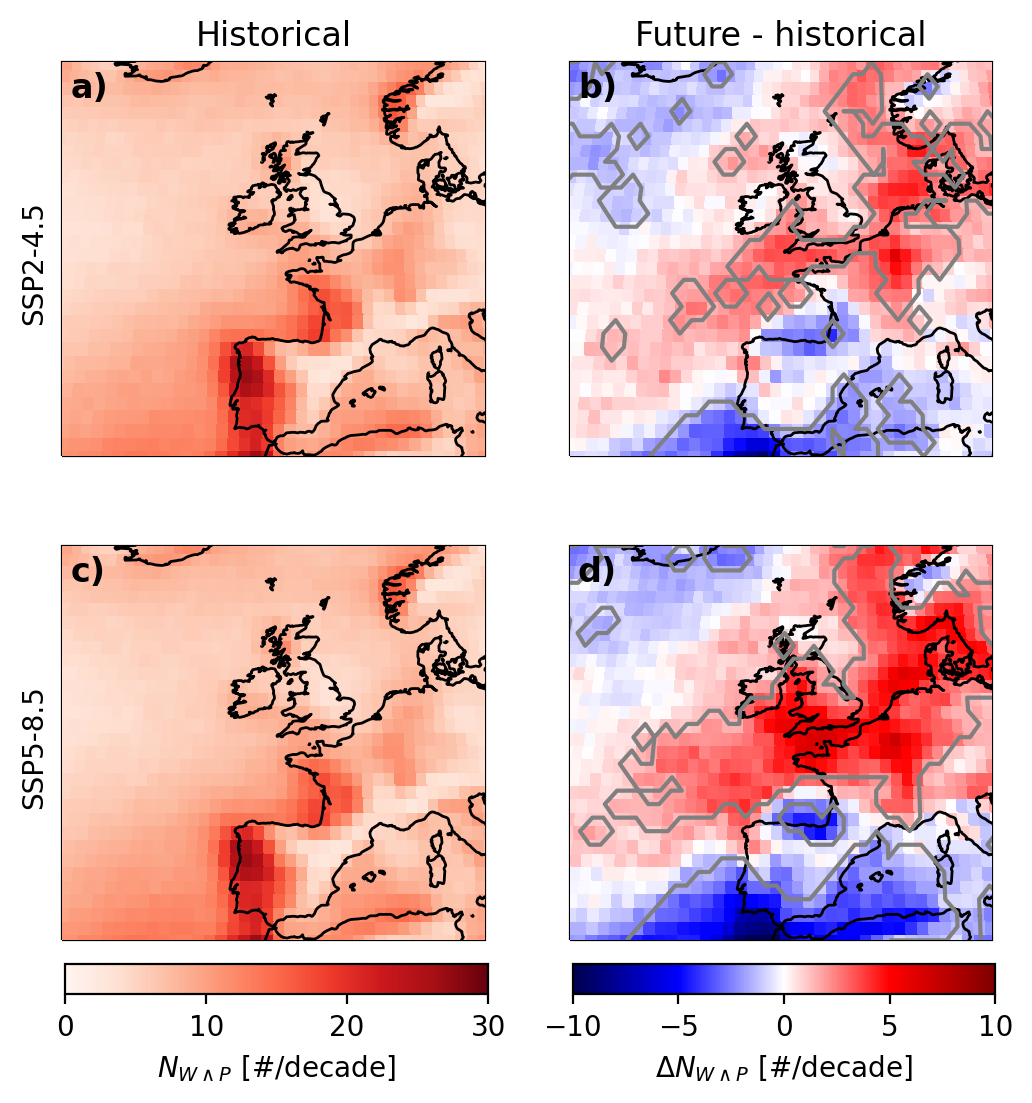

In [62]:
fig=plt.figure(figsize=(6,6)) #generate figure  
gs = fig.add_gridspec(2,2)
gs.update(hspace=.1)
    
for s,ssp in enumerate(ssps):
    ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
    #ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    #1991-2020
    ax = plt.subplot(gs[s,0],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id')).plot(cmap='Reds',vmin=0,vmax=30,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
    ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$N_{W\wedge P}$ [#/decade]')
        ax.set_title('')
    if s==0:
        ax.set_title('Historical')

    ax.annotate(['SSP2-4.5','SSP5-8.5'][s],(-.1,.35),xycoords='axes fraction',rotation=90)
    ax.annotate('ac'[s]+')',(.02,.91),xycoords='axes fraction',fontweight='bold',fontsize=12,zorder=10)
    sc.set_edgecolor('face')
    
    ax = plt.subplot(gs[s,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id')
    ens_diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')

    num_agree = ((diff*ens_diff)>0).sum(dim='source_id')
    fraction_exceeds = (num_agree>=.75*len(diff.source_id))
        
    #sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[~fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,edgecolor='black',transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    mean_lt_std = np.abs(ens_diff)>np.abs(ssp_ds_diff.num_co_occurring.mean(dim='member_id').std(dim='source_id'))
    
    sc=(.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    mean_lt_std.plot.contour(levels=[0,1],ax=ax,transform=ccrs.PlateCarree(),zorder=5,colors=['grey','grey'])
    
    ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
    
    if s==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('Future - historical')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta N_{W\wedge P}$ [#/decade]')
    ax.annotate('bd'[s]+')',(.02,.91),xycoords='axes fraction',fontweight='bold',fontsize=12,zorder=10)    
    sc.set_edgecolor('face')

fig.savefig('Figures/ensmean_dN_WP.pdf',format='pdf',dpi=300,bbox_inches='tight')



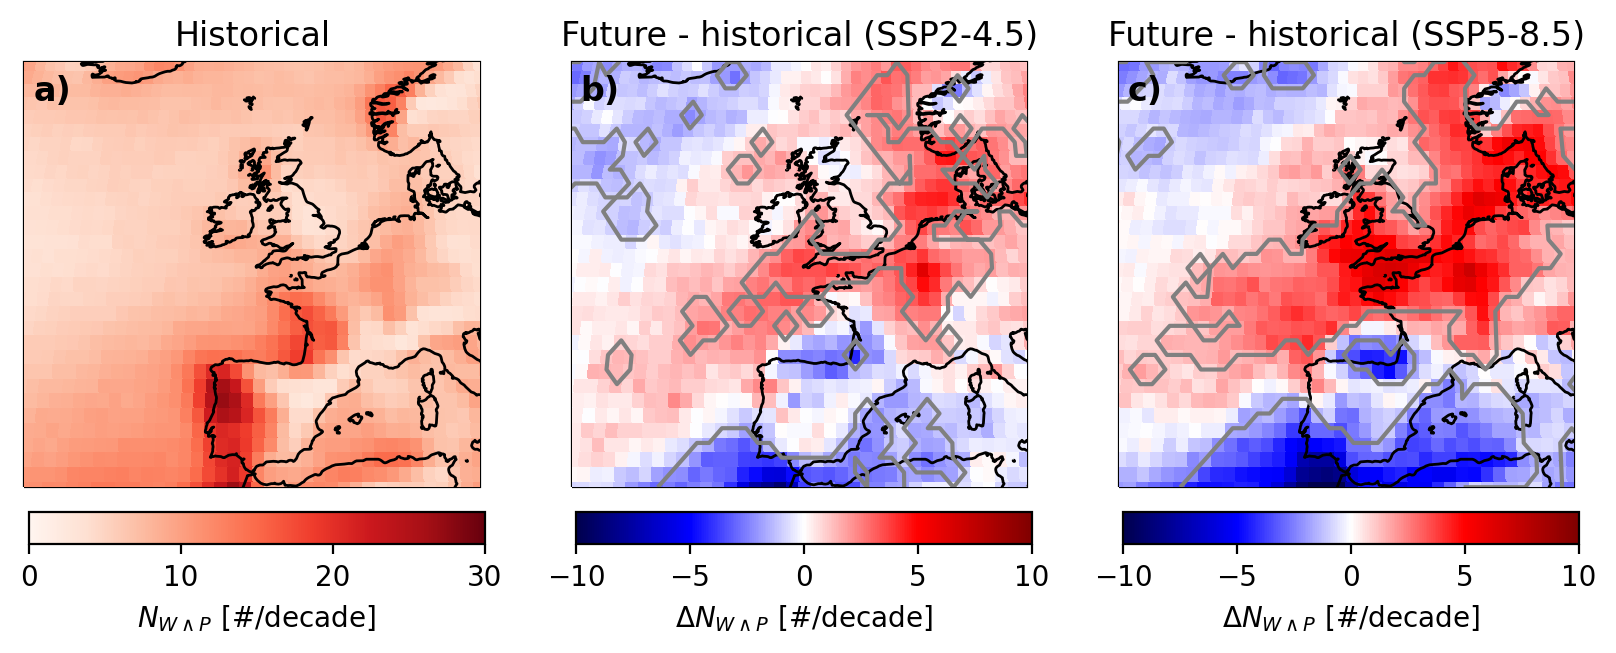

In [68]:
fig=plt.figure(figsize=(10,6)) #generate figure  
gs = fig.add_gridspec(1,3)
gs.update(hspace=.1)
    
for s,ssp in enumerate(ssps):
    ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
    #ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    if s==0:
        #1991-2020
        ax = plt.subplot(gs[s,0],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        #sc=(.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id')).plot(cmap='Reds',vmin=0,vmax=30,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)

        sc=(.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id')).plot(cmap='Reds',vmin=0,vmax=30,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)

        ax.coastlines(zorder=5)
        #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$N_{W\wedge P}$ [#/decade]')
        ax.set_title('')

        ax.set_title('Historical')

        ax.annotate('ac'[s]+')',(.02,.91),xycoords='axes fraction',fontweight='bold',fontsize=12,zorder=10)
        sc.set_edgecolor('face')
    
    ax = plt.subplot(gs[0,1+s],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id')
    ens_diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')

    num_agree = ((diff*ens_diff)>0).sum(dim='source_id')
    fraction_exceeds = (num_agree>=.75*len(diff.source_id))
        
    #sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[~fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,edgecolor='black',transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    mean_lt_std = np.abs(ens_diff)>np.abs(ssp_ds_diff.num_co_occurring.mean(dim='member_id').std(dim='source_id'))
    
    sc=(.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    mean_lt_std.plot.contour(levels=[0,1],ax=ax,transform=ccrs.PlateCarree(),zorder=5,colors=['grey','grey'])
    
    ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
    
    if s==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('Future - historical (SSP2-4.5)')
    if s==1:
        ax.set_title('Future - historical (SSP5-8.5)')
    cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
    cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta N_{W\wedge P}$ [#/decade]')
    ax.annotate('bc'[s]+')',(.02,.91),xycoords='axes fraction',fontweight='bold',fontsize=12,zorder=10)    
    sc.set_edgecolor('face')
fig.savefig('Figures/ensmean_dN_WP.pdf',format='pdf',dpi=300,bbox_inches='tight')


In [99]:
(.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id')).min()

<xarray.DataArray 'num_co_occurring' ()>
array(2.32638889)
Coordinates:
    window   int64 2000
    height   float64 10.0
    ssp      <U6 'ssp585'

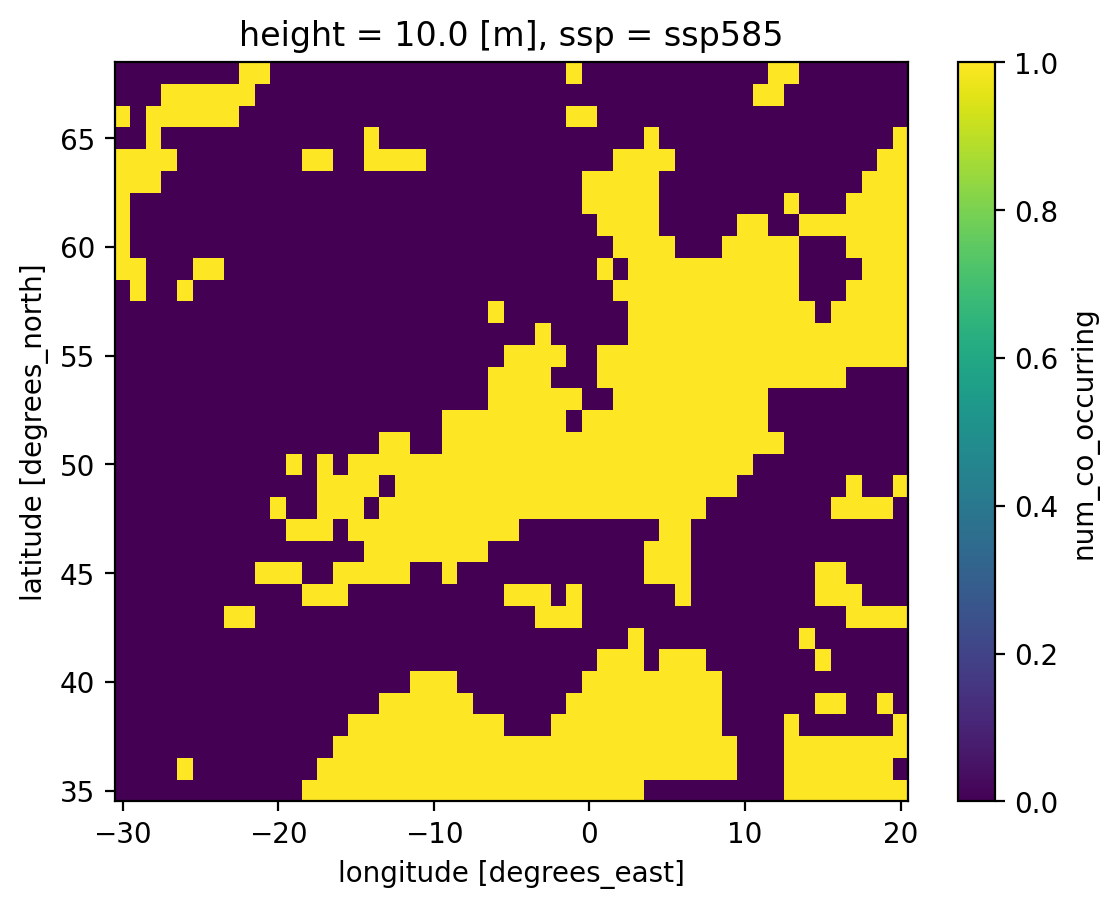

In [24]:
mean_lt_std.plot()

Decomposition:

'\nax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))\n\nsc = (.25*(mri_dependence.sel(member_id=\'r1i1p1f1\',window=2080).num_co_occurring.sum(dim=\'month\',skipna=False)-mri_dependence.sel(member_id=\'r1i1p1f1\',window=1980).num_co_occurring.sum(dim=\'month\',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap=\'seismic\',add_colorbar=False)\nax.coastlines(zorder=2)\n\ncax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)\ncb=fig.colorbar(sc, cax=cax,orientation=\'horizontal\',label=\'$\\Delta$Co-oc extremes [#/decade]\')\nax.set_title(\'total change (recomputing 98%)\')   \n\n\nax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))\n\nsc = (.25*(num_co_occurring.mean(dim=\'member_id\').sel(window=2080)-mri_dependence.sel(member_id=\'r1i1p1f1\',window=2080).num_co_occurring.sum(dim=\'month\',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cma

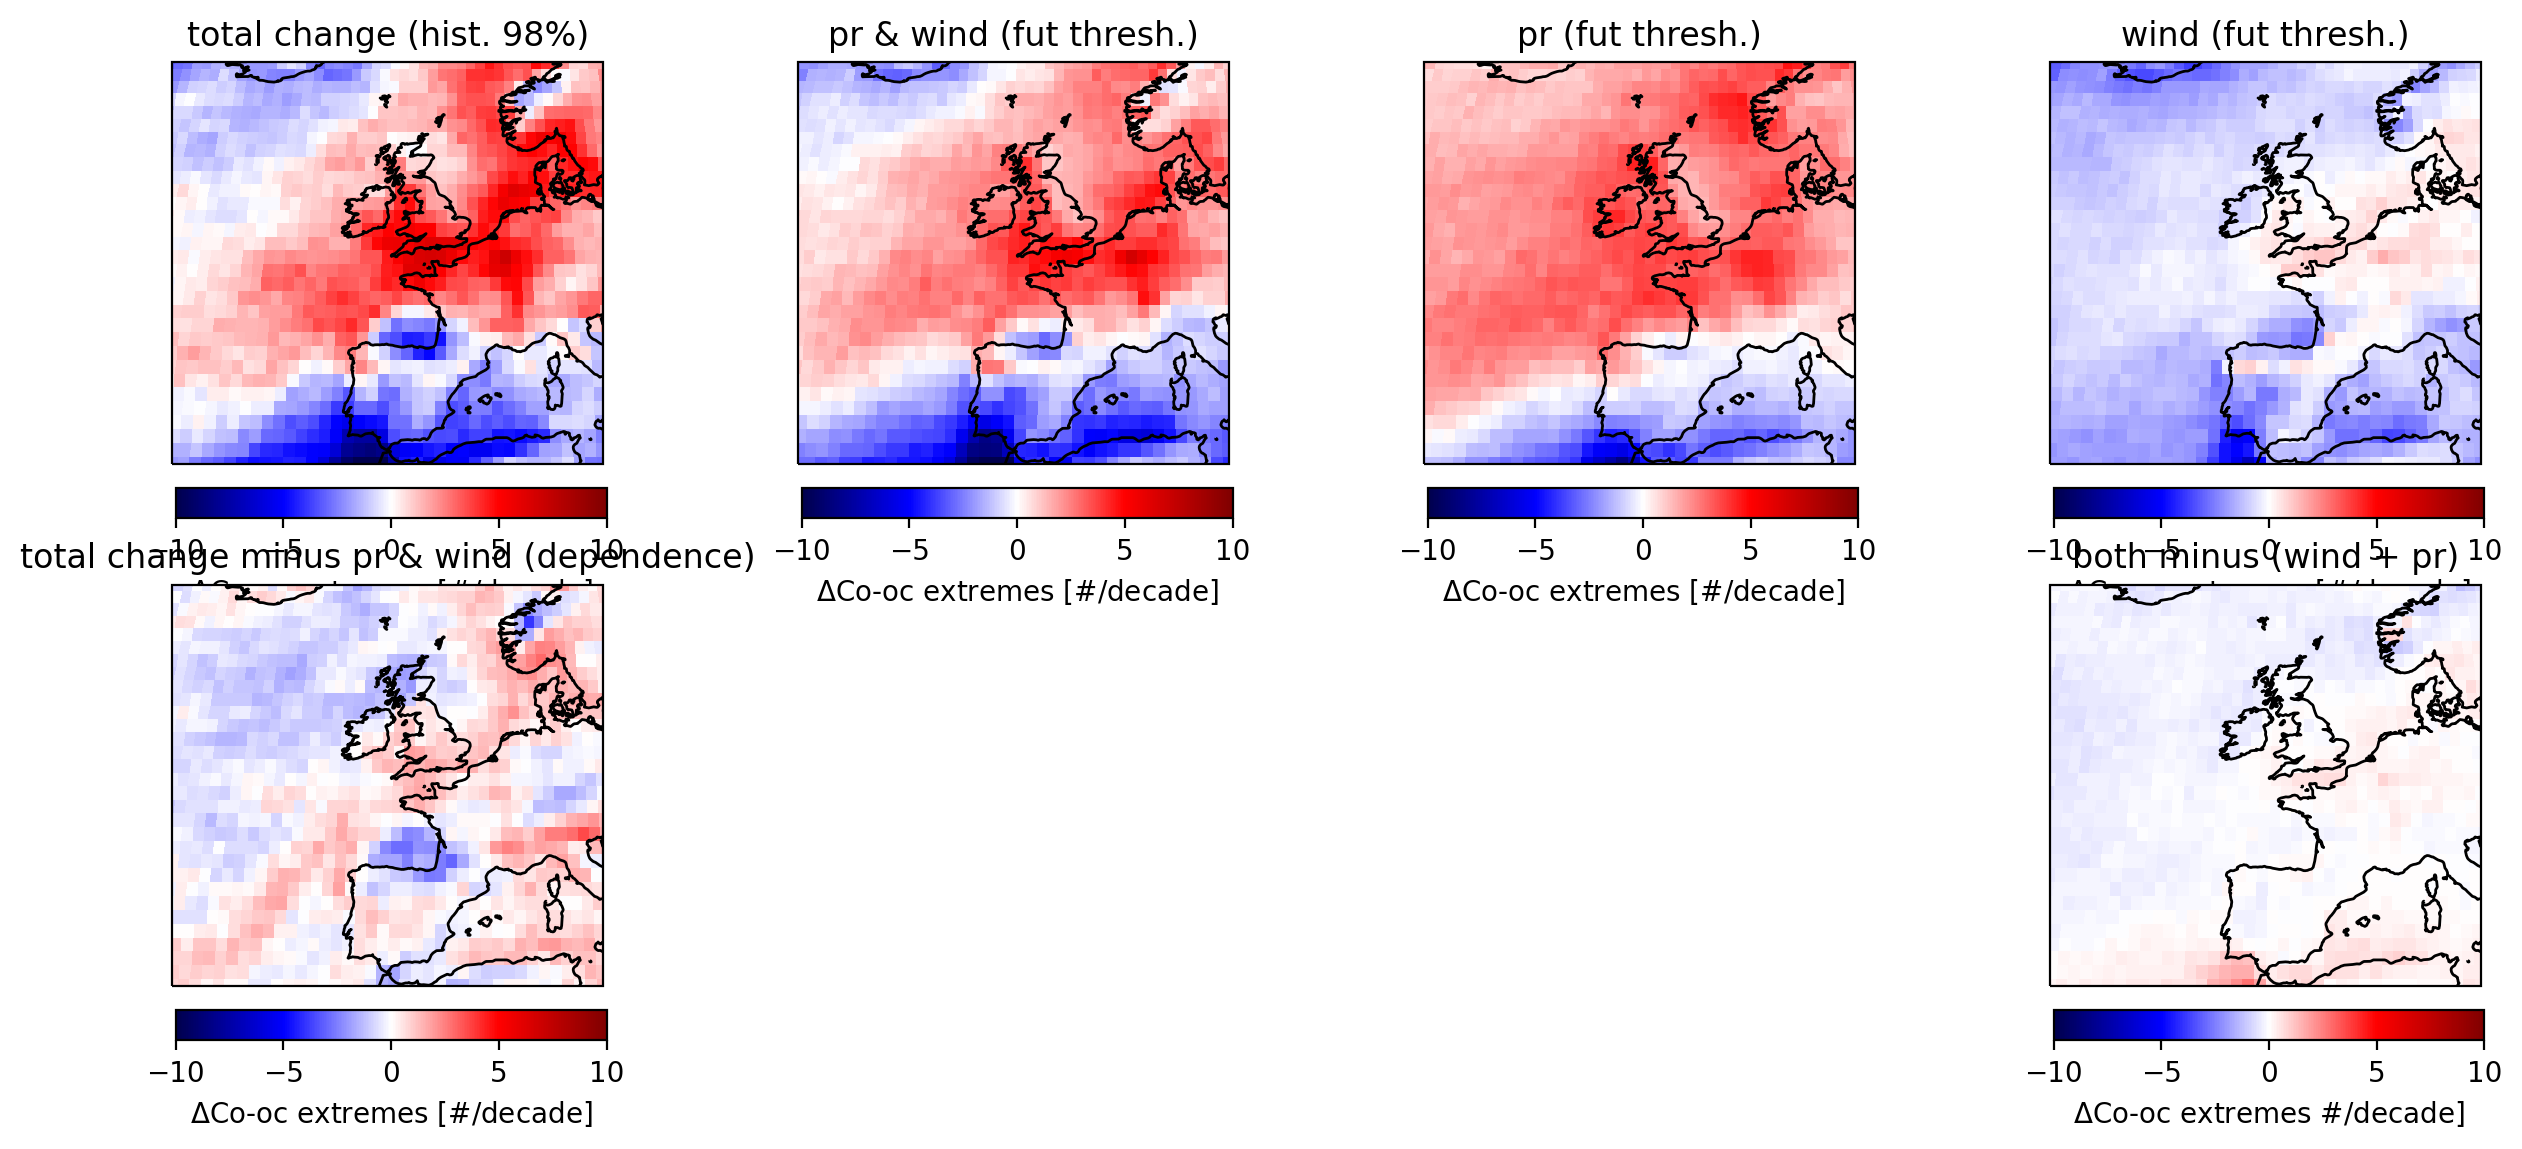

In [71]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,4)
gs.update(wspace=.4,hspace=.3)

ssp='ssp585'

ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
#ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
ssp_ds_diff = ssp_ds_future - ssp_ds_present

    
#1991-2020
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('total change (hist. 98%)')
ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
ax.annotate('a)',(.02,.91),xycoords='axes fraction',fontweight='bold',fontsize=12,zorder=10)  

ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

both_driven = (ssp_ds.num_co_occurring_both_driven-ssp_ds_present.num_co_occurring)

sc = (.25*both_driven.mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('pr & wind (fut thresh.)')
ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())

ax = plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=0))

pr_driven = (ssp_ds.num_co_occurring_pr_driven-ssp_ds_present.num_co_occurring)

sc = (.25*pr_driven.mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('pr (fut thresh.)')
ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())

ax = plt.subplot(gs[0,3],projection=ccrs.Robinson(central_longitude=0))

sfcWind_driven = (ssp_ds.num_co_occurring_sfcWind_driven-ssp_ds_present.num_co_occurring)

sc = (.25*sfcWind_driven.mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('wind (fut thresh.)')    
ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())

#sc=ax.scatter(sfcWind_peaks_hist.lon,sfcWind_peaks_hist.lat,c=sfcWind_peaks_hist.has_track.sum(dim='time')/np.isfinite(sfcWind_peaks_hist.sfcWind).sum(dim='time'),cmap='Reds',vmin=0,vmax=.8,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

#cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
#cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='Fraction etcs/extremes [-]')

ax = plt.subplot(gs[1,3],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(both_driven-(sfcWind_driven+pr_driven)).mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes #/decade]')
ax.set_title('both minus (wind + pr)')   
ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
dependence_driven = (ssp_ds_future.num_co_occurring-ssp_ds.num_co_occurring_both_driven)

ax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*dependence_driven.mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('total change minus pr & wind (dependence)')   
ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())



'''
ax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(mri_dependence.sel(member_id='r1i1p1f1',window=2080).num_co_occurring.sum(dim='month',skipna=False)-mri_dependence.sel(member_id='r1i1p1f1',window=1980).num_co_occurring.sum(dim='month',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)
ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('total change (recomputing 98%)')   


ax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(num_co_occurring.mean(dim='member_id').sel(window=2080)-mri_dependence.sel(member_id='r1i1p1f1',window=2080).num_co_occurring.sum(dim='month',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)
ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('d98-d97 future')   
'''


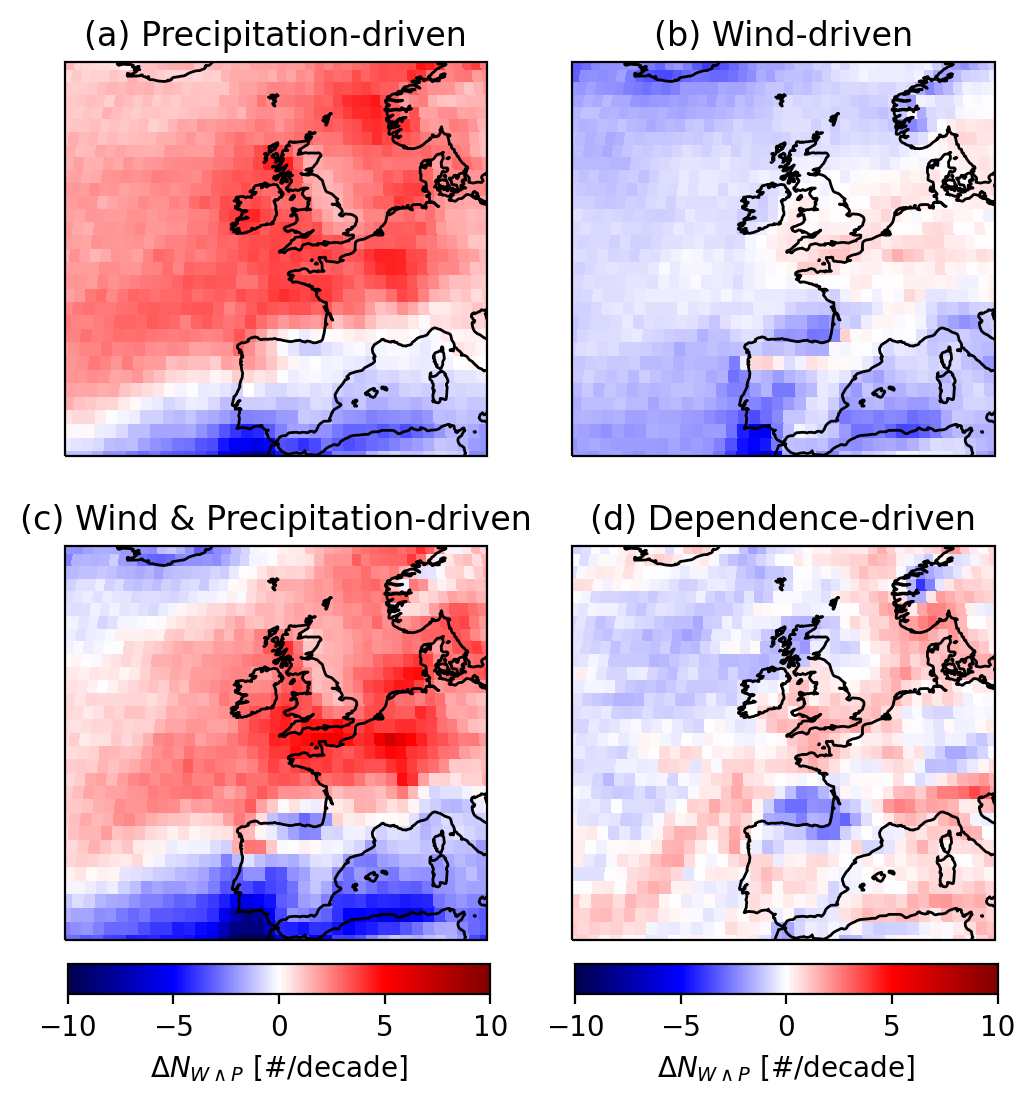

In [102]:
fig=plt.figure(figsize=(6,6)) #generate figure  
gs = fig.add_gridspec(2,2)
gs.update(hspace=.1)

ssp='ssp585'

ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
#ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
ssp_ds_diff = ssp_ds_future - ssp_ds_present

##PR
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

pr_driven = (ssp_ds.num_co_occurring_pr_driven-ssp_ds_present.num_co_occurring)

sc = (.25*pr_driven.mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)
sc.set_edgecolor('face')
ax.coastlines(zorder=2)


ax.set_title('(a) Precipitation-driven')
ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())

ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

##WIND
sfcWind_driven = (ssp_ds.num_co_occurring_sfcWind_driven-ssp_ds_present.num_co_occurring)

sc = (.25*sfcWind_driven.mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)
sc.set_edgecolor('face')
ax.coastlines(zorder=2)


ax.set_title('(b) Wind-driven')    
ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
  
##BOTH
ax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))

both_driven = (ssp_ds.num_co_occurring_both_driven-ssp_ds_present.num_co_occurring)

sc = (.25*both_driven.mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)
sc.set_edgecolor('face')
ax.coastlines(zorder=2)

ax.set_title('(c) Wind & Precipitation-driven')
ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta N_{W\wedge P}$ [#/decade]')
  
ax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))


##DEPENDENCE
dependence_driven = (ssp_ds_future.num_co_occurring-ssp_ds.num_co_occurring_both_driven)

ax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*dependence_driven.mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)
sc.set_edgecolor('face')
ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta N_{W\wedge P}$ [#/decade]')
ax.set_title('(d) Dependence-driven')   
ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())

fig.savefig('Figures/ensmean_dN_WP_decomp.jpg',format='jpg',dpi=300,bbox_inches='tight')



Uncertainty in terms:

'\nax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))\n\nsc = (.25*(mri_dependence.sel(member_id=\'r1i1p1f1\',window=2080).num_co_occurring.sum(dim=\'month\',skipna=False)-mri_dependence.sel(member_id=\'r1i1p1f1\',window=1980).num_co_occurring.sum(dim=\'month\',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap=\'Reds\',add_colorbar=False)\nax.coastlines(zorder=2)\n\ncax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)\ncb=fig.colorbar(sc, cax=cax,orientation=\'horizontal\',label=\'$\\Delta$Co-oc extremes [#/decade]\')\nax.set_title(\'total change (recomputing 98%)\')   \n\n\nax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))\n\nsc = (.25*(num_co_occurring.mean(dim=\'member_id\').sel(window=2080)-mri_dependence.sel(member_id=\'r1i1p1f1\',window=2080).num_co_occurring.sum(dim=\'month\',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap=\'Reds\

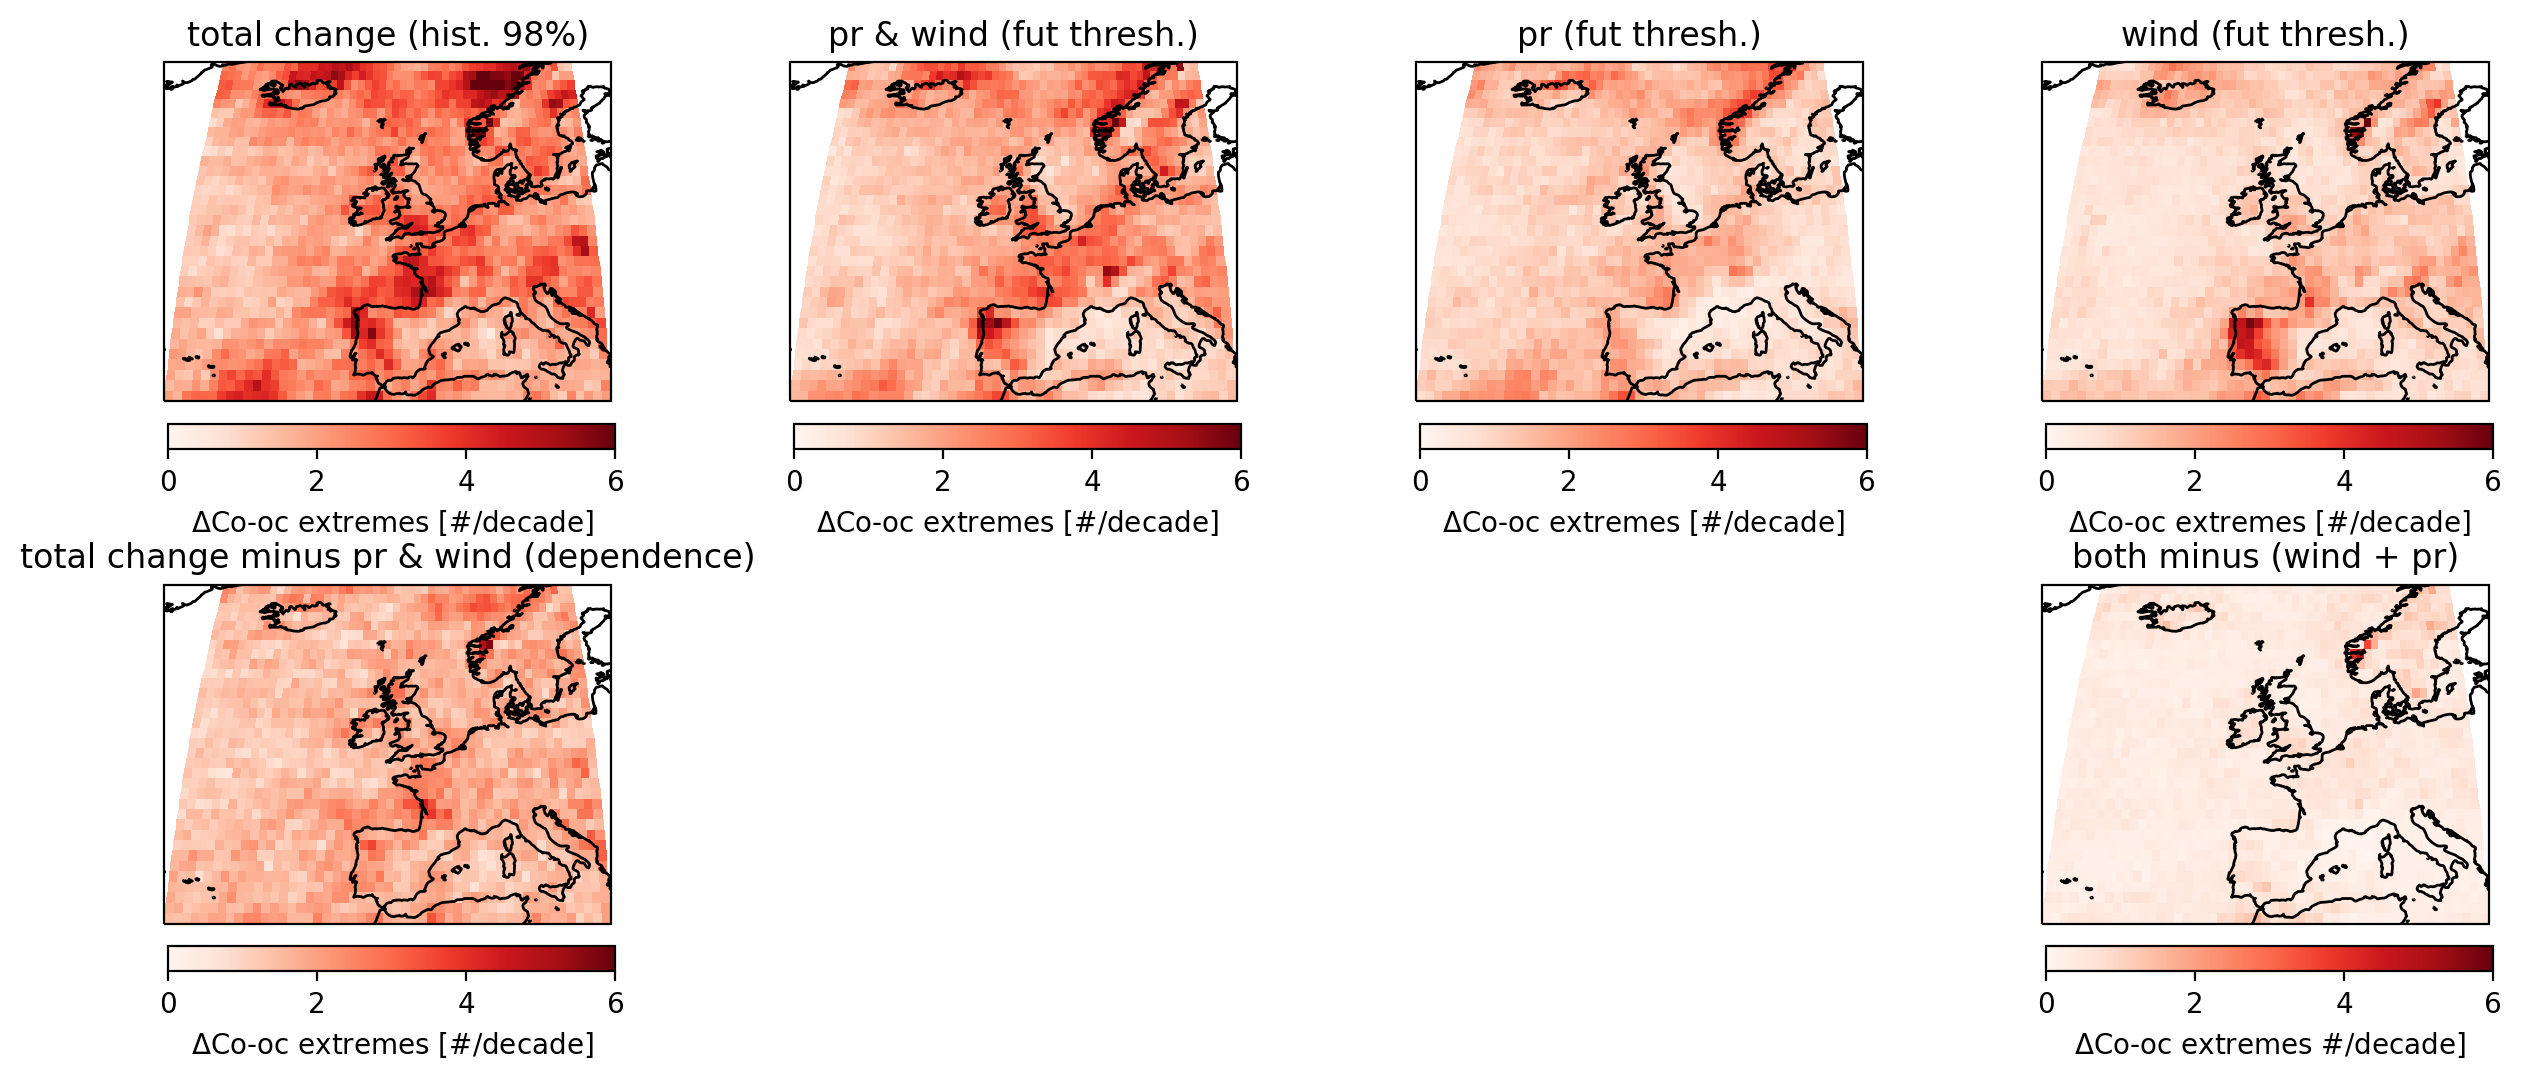

In [9]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,4)
gs.update(wspace=.4,hspace=.3)

ssp='ssp585'

ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
#ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
ssp_ds_diff = ssp_ds_future - ssp_ds_present

    
#1991-2020
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').std(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap='Reds',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('total change (hist. 98%)')


ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

both_driven = (ssp_ds.num_co_occurring_both_driven-ssp_ds_present.num_co_occurring)

sc = (.25*both_driven.mean(dim='member_id').std(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap='Reds',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('pr & wind (fut thresh.)')

ax = plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=0))

pr_driven = (ssp_ds.num_co_occurring_pr_driven-ssp_ds_present.num_co_occurring)

sc = (.25*pr_driven.mean(dim='member_id').std(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap='Reds',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('pr (fut thresh.)')


ax = plt.subplot(gs[0,3],projection=ccrs.Robinson(central_longitude=0))

sfcWind_driven = (ssp_ds.num_co_occurring_sfcWind_driven-ssp_ds_present.num_co_occurring)

sc = (.25*sfcWind_driven.mean(dim='member_id').std(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap='Reds',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('wind (fut thresh.)')    


#sc=ax.scatter(sfcWind_peaks_hist.lon,sfcWind_peaks_hist.lat,c=sfcWind_peaks_hist.has_track.sum(dim='time')/np.isfinite(sfcWind_peaks_hist.sfcWind).sum(dim='time'),cmap='Reds',vmin=0,vmax=.8,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

#cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
#cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='Fraction etcs/extremes [-]')

ax = plt.subplot(gs[1,3],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(both_driven-(sfcWind_driven+pr_driven)).mean(dim='member_id').std(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap='Reds',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes #/decade]')
ax.set_title('both minus (wind + pr)')   

dependence_driven = (ssp_ds_future.num_co_occurring-ssp_ds.num_co_occurring_both_driven)

ax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*dependence_driven.mean(dim='member_id').std(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap='Reds',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('total change minus pr & wind (dependence)')   

'''
ax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))

sc = (np.abs(dependence_driven.mean(dim='member_id').mean(dim='source_id'))>np.abs(pr_driven.mean(dim='member_id').mean(dim='source_id'))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=1,cmap='Reds',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('dependence>pr')   

ax = plt.subplot(gs[1,2],projection=ccrs.Robinson(central_longitude=0))

sc = (np.abs(dependence_driven.mean(dim='member_id').mean(dim='source_id'))>np.abs(sfcWind_driven.mean(dim='member_id').mean(dim='source_id'))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=1,cmap='Reds',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('dependence>wind')   
'''


'''
ax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(mri_dependence.sel(member_id='r1i1p1f1',window=2080).num_co_occurring.sum(dim='month',skipna=False)-mri_dependence.sel(member_id='r1i1p1f1',window=1980).num_co_occurring.sum(dim='month',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap='Reds',add_colorbar=False)
ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('total change (recomputing 98%)')   


ax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(num_co_occurring.mean(dim='member_id').sel(window=2080)-mri_dependence.sel(member_id='r1i1p1f1',window=2080).num_co_occurring.sum(dim='month',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap='Reds',add_colorbar=False)
ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('d98-d97 future')   
'''


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


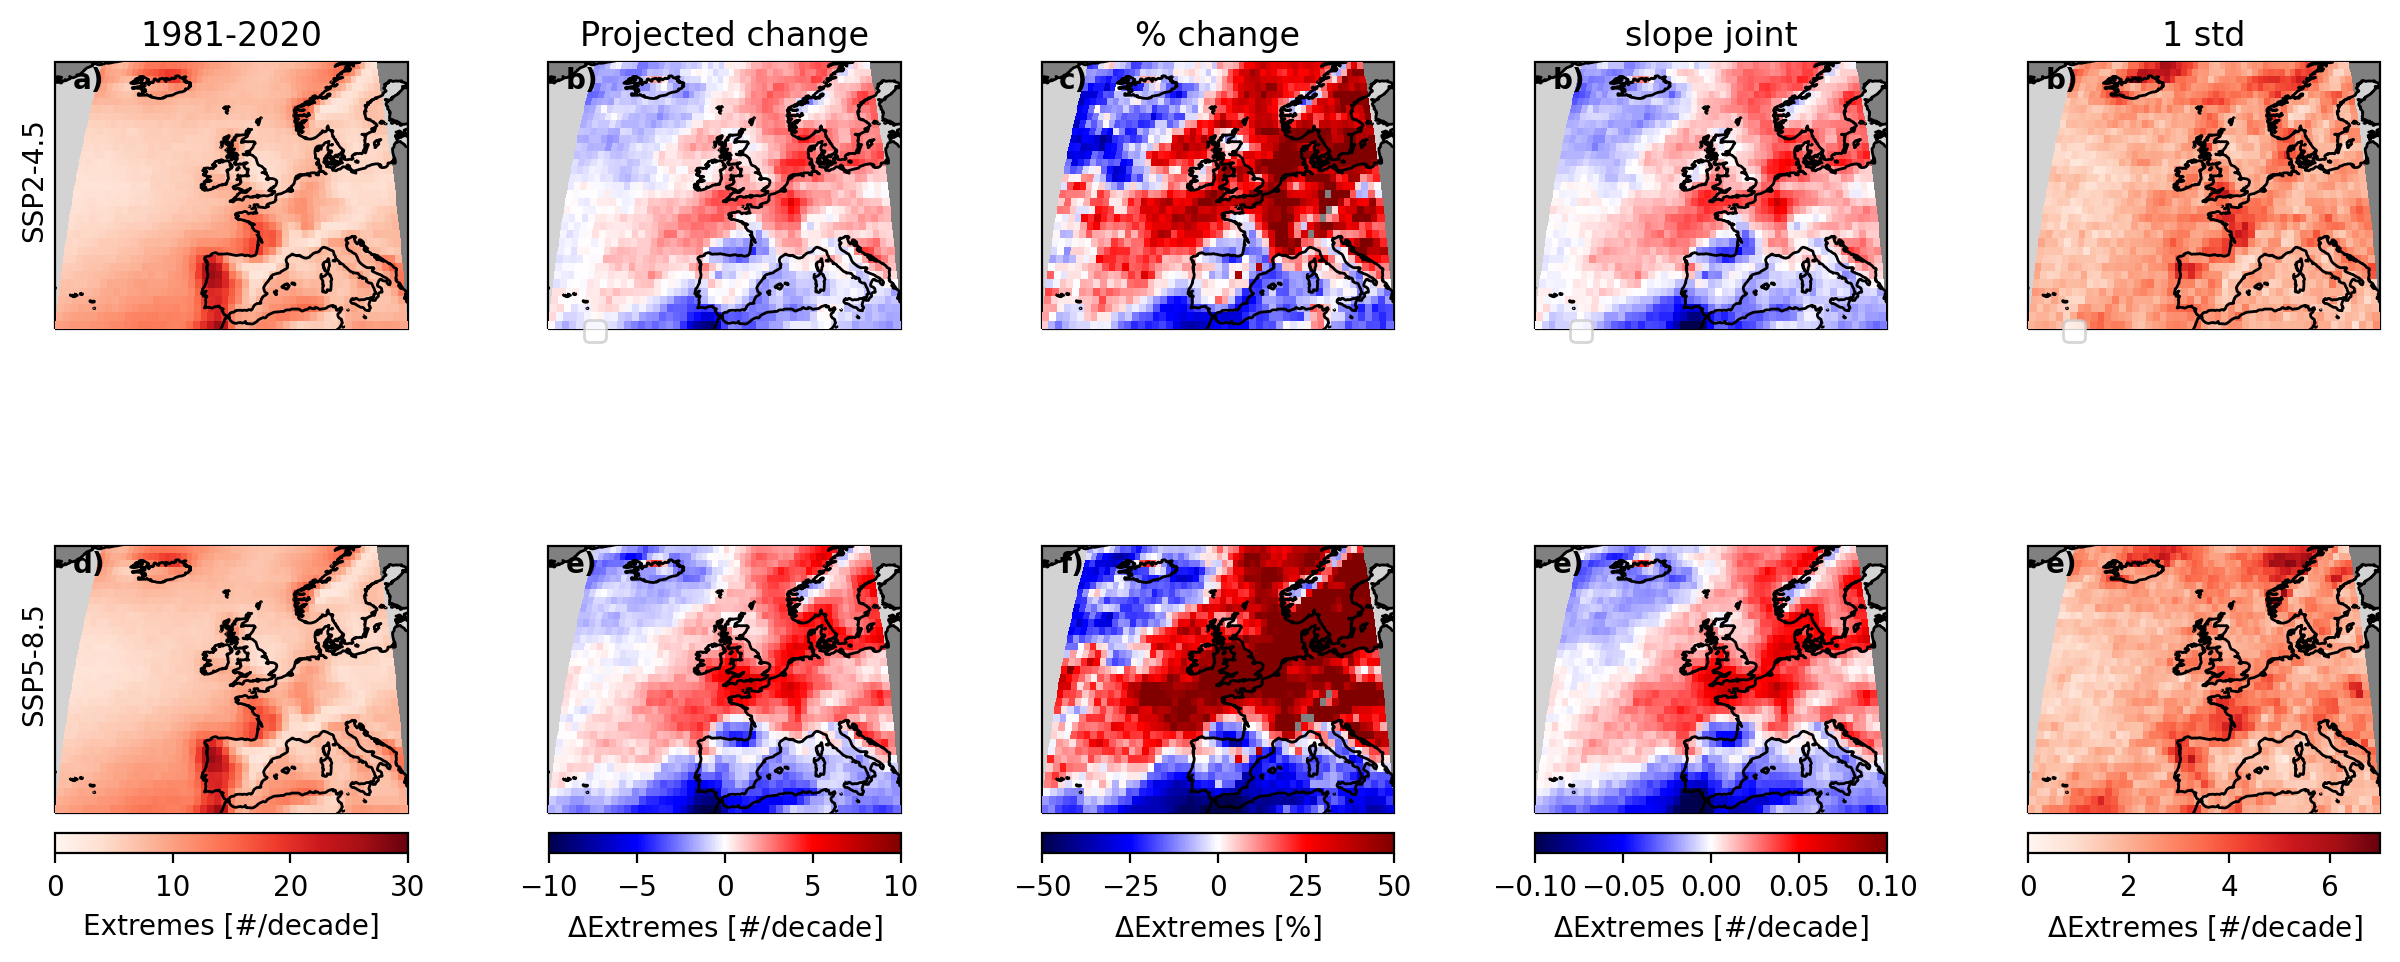

In [46]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,5)
gs.update(wspace=.4,hspace=.1)
    
for s,ssp in enumerate(ssps):
    ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
    #ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    #1991-2020
    ax = plt.subplot(gs[s,0],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id')).plot(cmap='Reds',vmin=0,vmax=30,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Extremes [#/decade]')
        ax.set_title('')
    if s==0:
        ax.set_title('1981-2020')

    ax.annotate(['SSP2-4.5','SSP5-8.5'][s],(-.1,.35),xycoords='axes fraction',rotation=90)
    ax.annotate('ad'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
       
    ax = plt.subplot(gs[s,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id')
    ens_diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')

    num_agree = ((diff*ens_diff)>0).sum(dim='source_id')
    fraction_exceeds = (num_agree>=.75*len(diff.source_id))
        
    #sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[~fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,edgecolor='black',transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    sc=(.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('Projected change')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
        
    ax = plt.subplot(gs[s,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(100*ssp_ds_diff.num_co_occurring/ssp_ds_present.num_co_occurring).mean(dim='member_id').mean(dim='source_id').plot(cmap='seismic',vmin=-50,vmax=50,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [%]')
        ax.set_title('')
    if s==0:
        ax.set_title('% change')
    ax.annotate('cf'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
#meaning of number of joint extremes?

#fig.savefig('Figures/ensmean_num_joint_extremes_knmi.pdf',format='pdf',dpi=300,bbox_inches='tight')


    
    ax = plt.subplot(gs[s,3],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_co_occurring,timesteps,dim='window')*ssp_ds.num_co_occurring.std(dim='window')/timesteps.std(dim='window')
    sc=(.25*slope.mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)    
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope joint')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    
    ax = plt.subplot(gs[s,4],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    
    sc=(.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').std(dim='source_id')).plot(cmap='Reds',vmin=0,vmax=7,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)    
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('1 std')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    
    
    
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


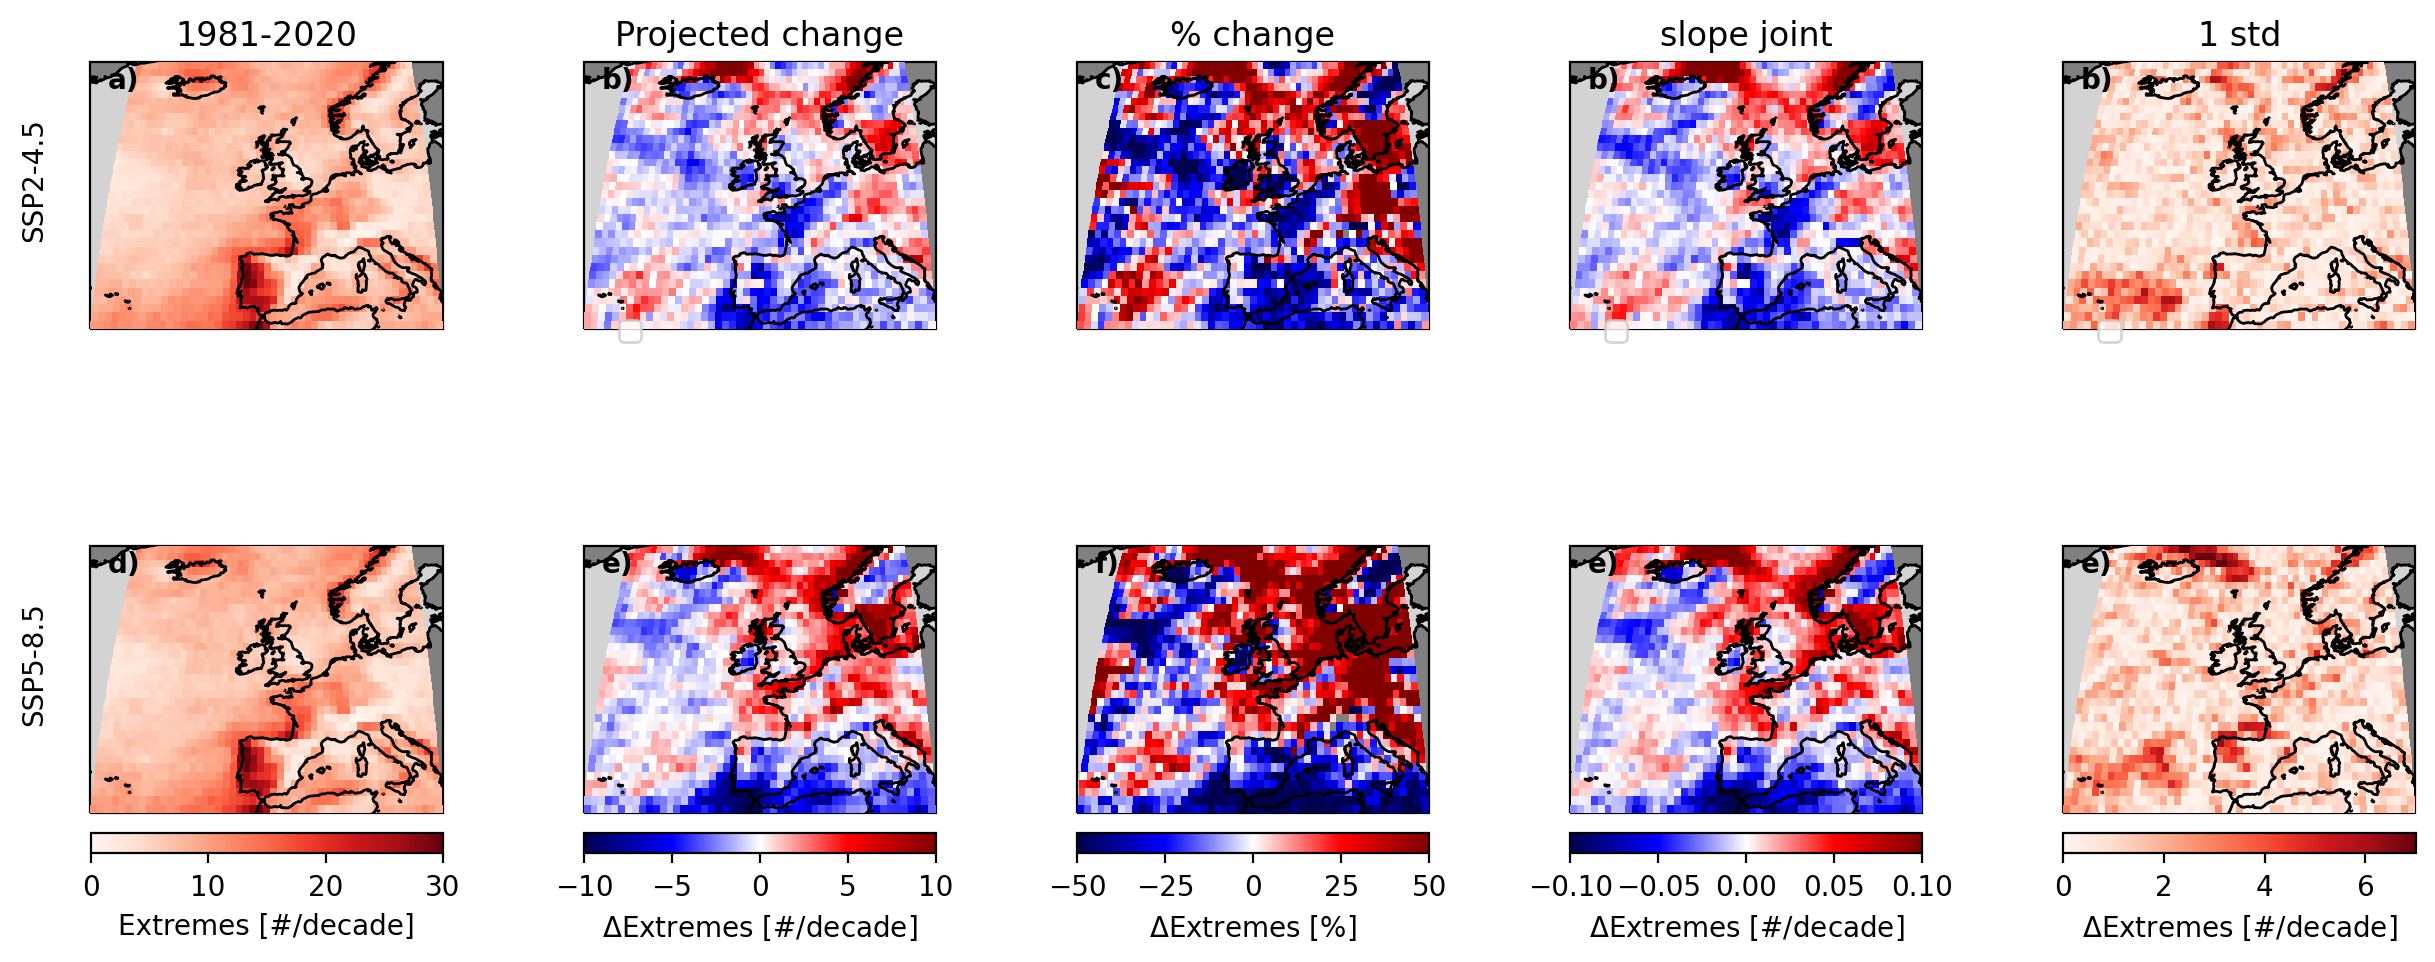

In [14]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,5)
gs.update(wspace=.4,hspace=.1)
    
for s,ssp in enumerate(ssps):
    ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False).sel(source_id='EC-Earth3')
    #ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    #1991-2020
    ax = plt.subplot(gs[s,0],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(.25*ssp_ds_present.num_co_occurring.mean(dim='member_id')).plot(cmap='Reds',vmin=0,vmax=30,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Extremes [#/decade]')
        ax.set_title('')
    if s==0:
        ax.set_title('1981-2020')

    ax.annotate(['SSP2-4.5','SSP5-8.5'][s],(-.2,.35),xycoords='axes fraction',rotation=90)
    ax.annotate('ad'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
       
    ax = plt.subplot(gs[s,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    #diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id')
    #ens_diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id')

    #num_agree = ((diff*ens_diff)>0).sum(dim='source_id')
    #fraction_exceeds = (num_agree>=.75*len(diff.source_id))
        
    #sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[~fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,edgecolor='black',transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    sc=(.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id')).plot(cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('Projected change')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
        
    ax = plt.subplot(gs[s,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(100*ssp_ds_diff.num_co_occurring/ssp_ds_present.num_co_occurring).mean(dim='member_id').plot(cmap='seismic',vmin=-50,vmax=50,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [%]')
        ax.set_title('')
    if s==0:
        ax.set_title('% change')
    ax.annotate('cf'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
#meaning of number of joint extremes?

#fig.savefig('Figures/ensmean_num_joint_extremes_knmi.pdf',format='pdf',dpi=300,bbox_inches='tight')


    
    ax = plt.subplot(gs[s,3],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_co_occurring,timesteps,dim='window')*ssp_ds.num_co_occurring.std(dim='window')/timesteps.std(dim='window')
    sc=(.25*slope.mean(dim='member_id')).plot(cmap='seismic',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)    
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope joint')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    
    ax = plt.subplot(gs[s,4],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    
    sc=(.25*ssp_ds_diff.num_co_occurring.std(dim='member_id')).plot(cmap='Reds',vmin=0,vmax=7,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)    
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('1 std')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    
    
    
    

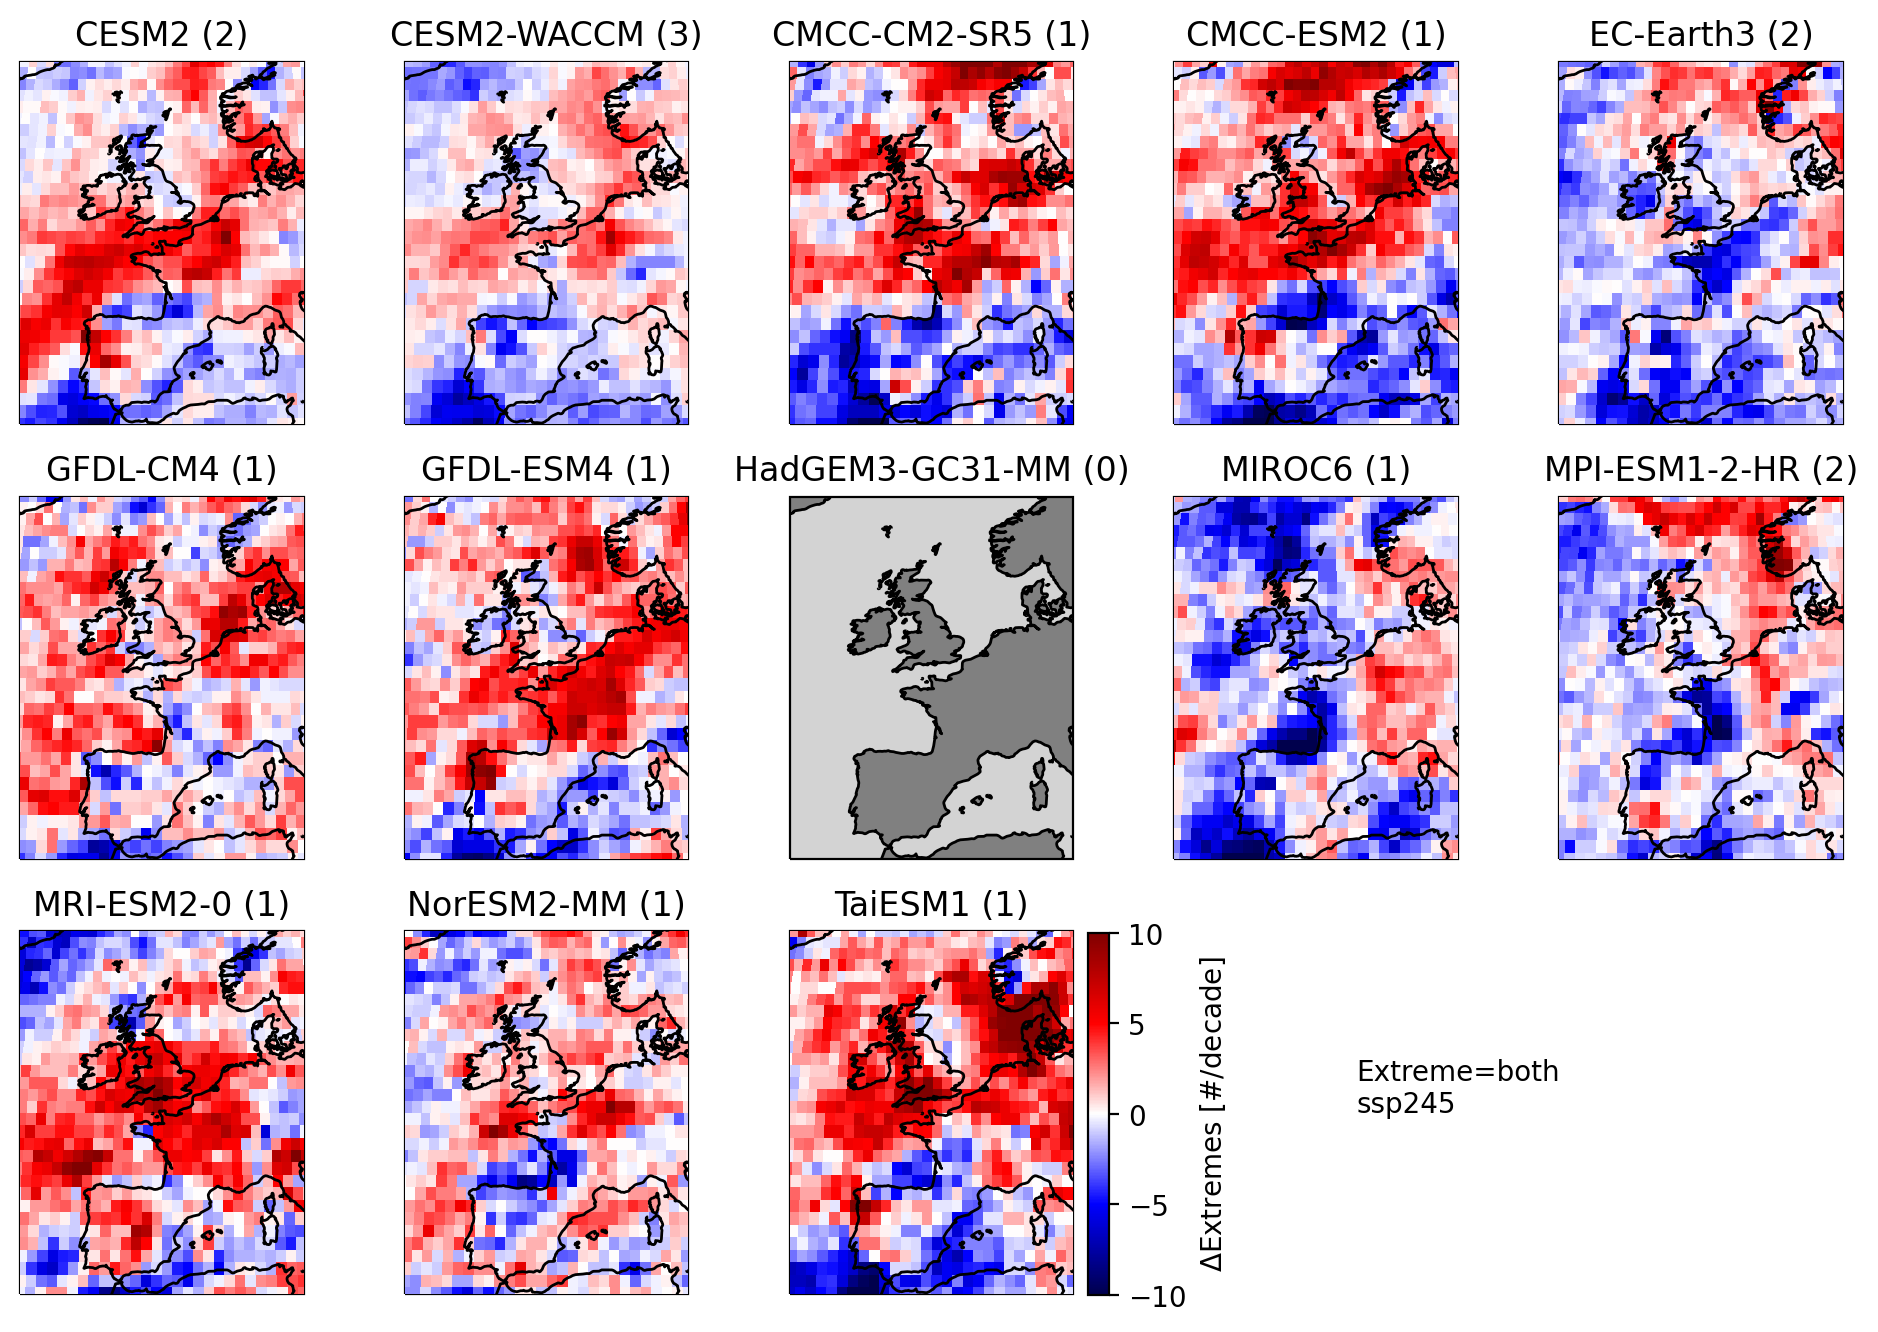

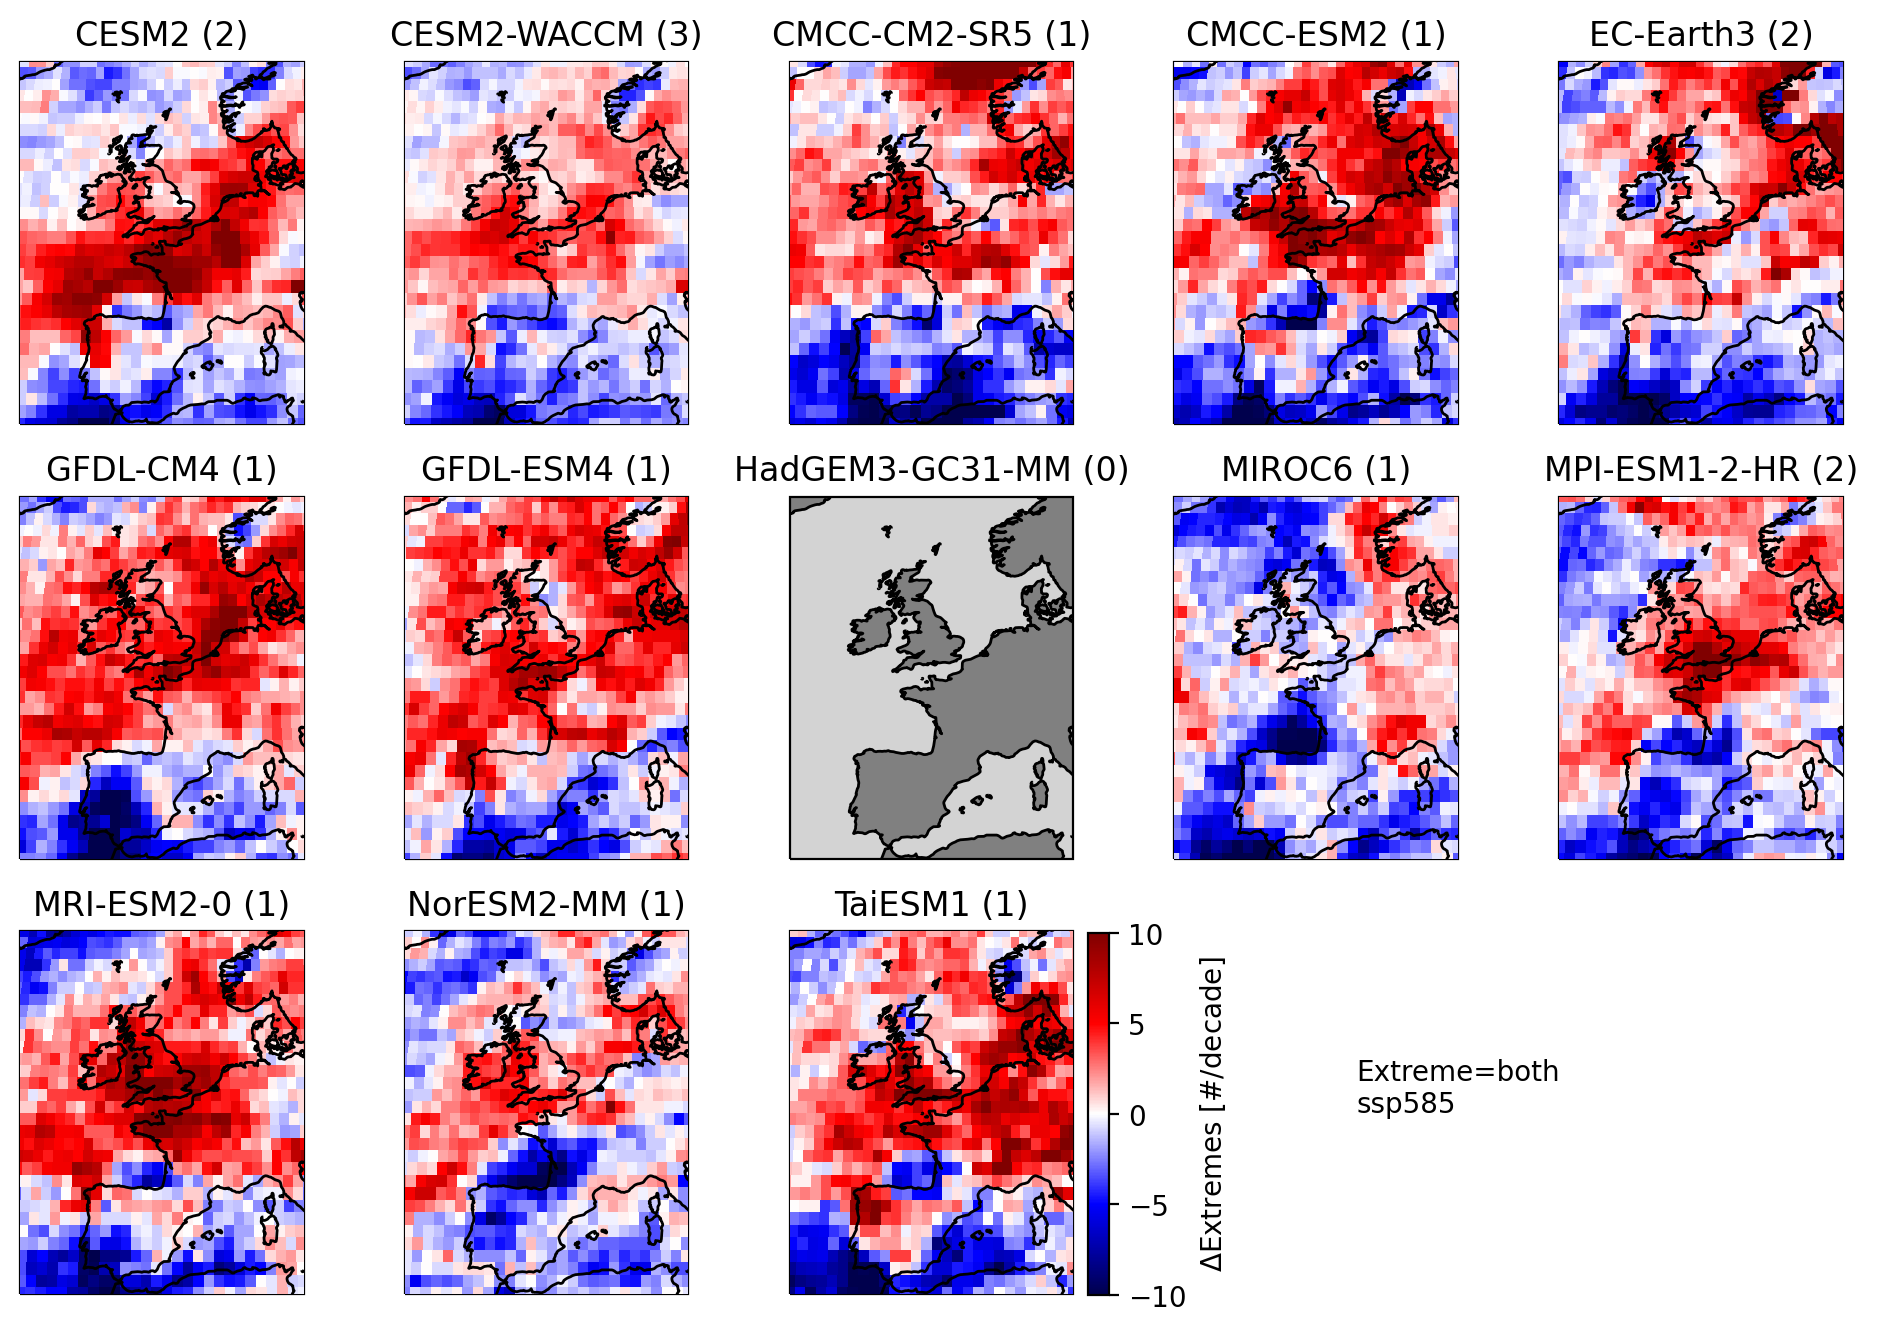

In [25]:
for ssp in ssps:
    ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)

    ssp_ds_present = ssp_ds.sel(window=2000)
    ssp_ds_future = ssp_ds.sel(window=2080)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    fig=plt.figure(figsize=(12,8)) #generate figure  
    gs = fig.add_gridspec(3,5)

    for m,model in enumerate(ssp_ds.source_id.values):
        #1991-2020
        ax = plt.subplot(gs[np.unravel_index(m,(3,5))],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=(.25*ssp_ds_diff.num_co_occurring.sel(source_id=model).mean(dim='member_id')).plot(cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
        ax.coastlines(zorder=5)    
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
        n_members = np.isfinite(ssp_ds_present.num_co_occurring.sel(source_id=model)).sum(dim='member_id')[0,0].values
        ax.set_title(model +' ('+str(n_members)+')')
        if m==len(ssp_ds.source_id.values)-1:
            cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
            cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='$\Delta$Extremes [#/decade]')
            ax.annotate('Extreme=both\n'+ssp,(2,.5),xycoords='axes fraction')